## Setup

Importing relevant libaries and reading data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
import os

### [IMPORTANT]

- This code relies on the csv files being in a folder called ```patch_csvs/``` located in the same directory as this script. Ensure that the folder has 2 kinds of csv files – metrics and patch length
- Also have ```case_grade_match.csv``` (can download from ML folder on GitHub) in the same directory as this script

In [89]:
# read all metrics and patch_length files from csv folder
csv_folder = './patch_csvs'
metrics_files = [f for f in os.listdir(csv_folder) if f.startswith('metrics')]
patch_length_files = [f for f in os.listdir(csv_folder) if f.startswith('patch_length')]

In [91]:
# read ground truth data
case_grade = pd.read_csv("case_grade_match.csv")

# Rename 'Case' to 'case' for consistent merging
case_grade = case_grade.rename(columns={"Case": "case"})
case_grade.head()

,case,Class
0,1,4
1,2,1
2,3,4
3,4,1
4,5,3


## Cleaning and Preparing Metrics Data

The following sections look at raw slice-level data without segregating by case classification (benign versus high-grade). See lower in the code for case-level aggregation

In [139]:
# create df to store patched image metrics data
metrics_df = pd.DataFrame(columns=['slice','num_patches', 'epithelium_coverage'])

# loop through all metrics csv files and add patch num + epithelium coverage values to above df
for f in metrics_files:
    path = os.path.join(csv_folder, f)
    df = pd.read_csv(path)
    slice_name = f.removeprefix("metrics_").removesuffix(".csv")
    metrics_df.loc[len(metrics_df)] = [slice_name, df.iloc[0,1], df.iloc[1,1]] # first val is num_patches, second val is epithelium_coverage

# extract case number
metrics_df['case'] = metrics_df['slice'].str.extract(r'case_(\d+)', expand=False)
metrics_df['case'] = metrics_df['case'].astype(int)

# add ground truth class label
metrics_df = metrics_df.merge(case_grade[['case', 'Class']], on='case', how='left')

metrics_df.head()

,slice,num_patches,epithelium_coverage,case,Class
0,case_15_unmatched_10_melan,153.0,92.838823,15,3
1,case_12_unmatched_1_melan,80.0,95.423090,12,3
2,case_061_match_1_h&e,269.0,92.939825,61,3
3,case_27_match_1_melan,61.0,95.203790,27,1
4,case_073_match_1_melan,403.0,95.330879,73,3


In [95]:
print("Total number of patches =", sum(metrics_df['num_patches']))

Total number of patches = 73162.0


### Significant Data Points for Metrics

In [101]:
# min number of patches
metrics_df.iloc[np.argmin(metrics_df['num_patches']),:]

slice                  case_16_match_1_melan
num_patches                              1.0
epithelium_coverage                86.700149
case                                      16
Class                                      4
Name: 70, dtype: object

In [103]:
# important statistics for patch number
print(np.median(metrics_df['num_patches']))
print(np.percentile(metrics_df['num_patches'], 25))
print(np.percentile(metrics_df['num_patches'], 75))
print(stats.mode(metrics_df['num_patches']))

97.0
54.0
155.0
ModeResult(mode=124.0, count=11)


In [259]:
# important statistics for epithelium coverage
print(np.median(metrics_df['epithelium_coverage']))
print(np.percentile(metrics_df['epithelium_coverage'], 25))
print(np.percentile(metrics_df['epithelium_coverage'], 75))

96.47512234946302
94.57270899551811
97.97503112556875


In [107]:
# min epithelium coverage
metrics_df.iloc[np.argmin(metrics_df['epithelium_coverage']),:]

slice                  case_38_match13_h&e
num_patches                           31.0
epithelium_coverage               67.73773
case                                    38
Class                                    4
Name: 241, dtype: object

## Metrics Distribution Analysis

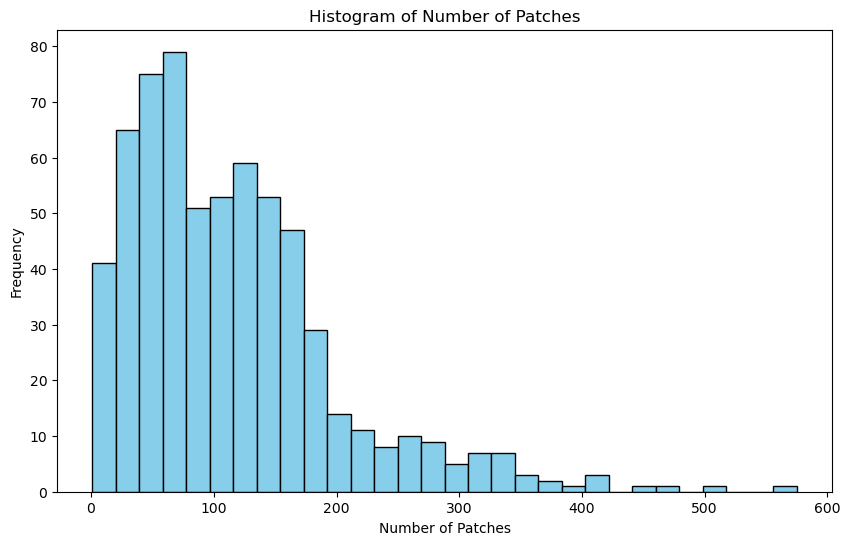

In [141]:
# histogram for number of patches
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['num_patches'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Patches')
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.show()

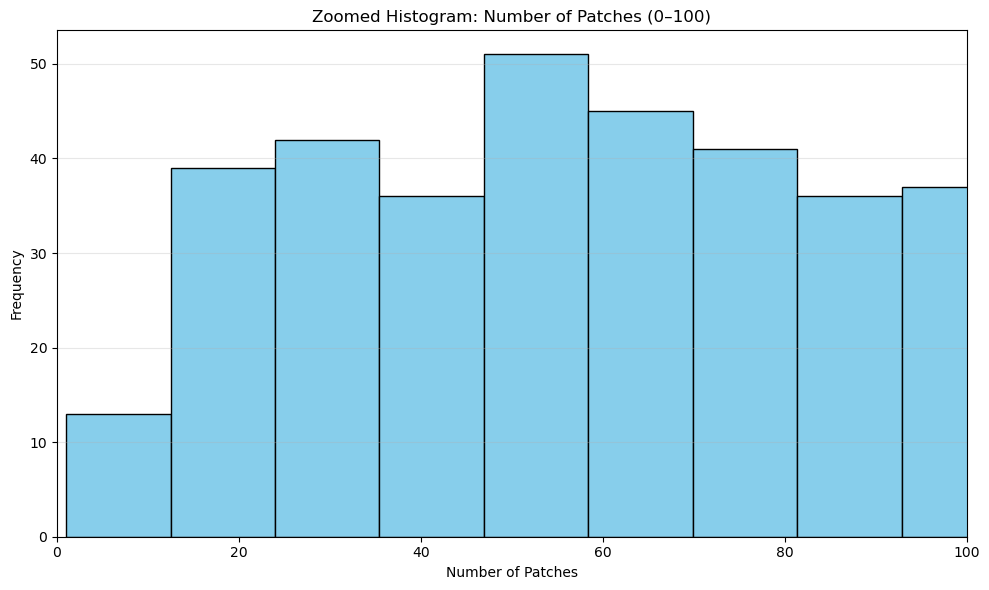

In [111]:
# zooming in
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['num_patches'], bins=50, color='skyblue', edgecolor='black')  # more bins = finer granularity
plt.xlim(0, 100)  # zoom in on 0–100 range
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.title('Zoomed Histogram: Number of Patches (0–100)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

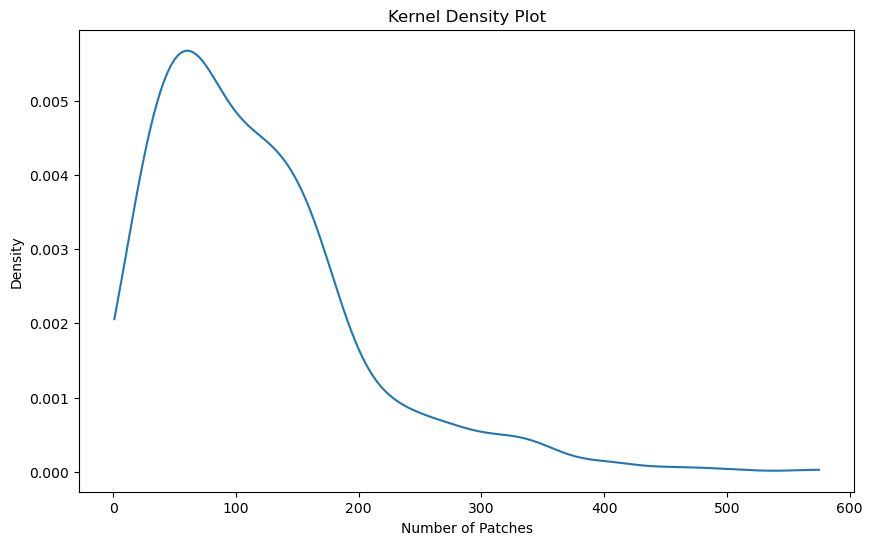

In [143]:
# density plot
density = gaussian_kde(metrics_df['num_patches'])

# Create a range of x values for plotting
x = np.linspace(min(metrics_df['num_patches']), max(metrics_df['num_patches']), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Number of Patches')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

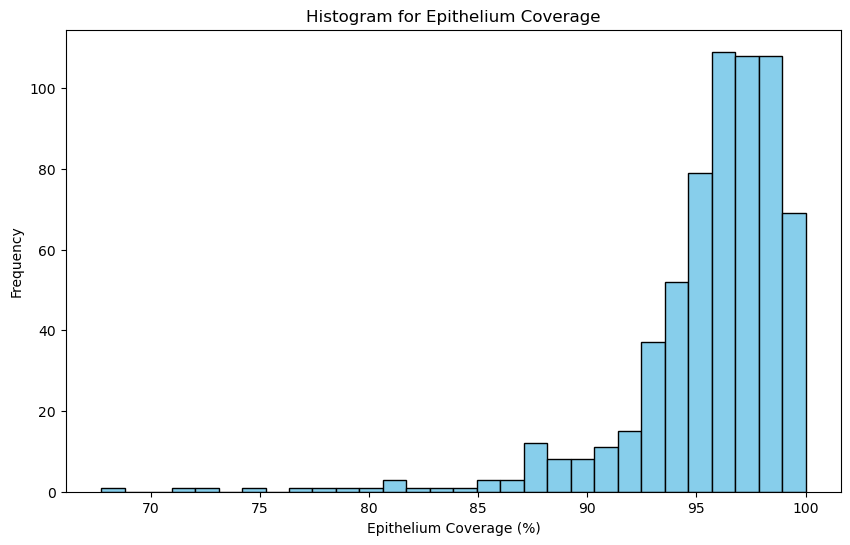

In [145]:
# histogram for epithelium coverage
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['epithelium_coverage'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Epithelium Coverage (%)')
plt.ylabel('Frequency')
plt.title('Histogram for Epithelium Coverage')
plt.show()

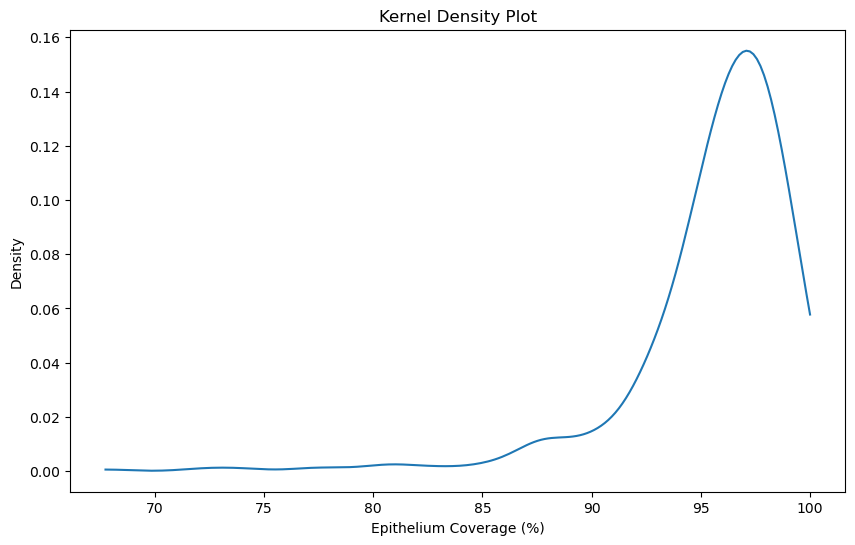

In [147]:
# density plot
density = gaussian_kde(metrics_df['epithelium_coverage'])

# Create a range of x values for plotting
x = np.linspace(min(metrics_df['epithelium_coverage']), max(metrics_df['epithelium_coverage']), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Epithelium Coverage (%)')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

## Cleaning and Preparing Patch Length Data

In [149]:
# create df to store patch length data
length_df = pd.DataFrame(columns=['slice','lengths'])

# list to store all lengths
nested_all_lens = []

# loop through all patch length csv files and add lengths to above df as a list
for f in patch_length_files:
    path = os.path.join(csv_folder, f)
    df = pd.read_csv(path)
    lens = df.values.ravel().tolist() # read all length values and create list
    nested_all_lens.append(lens) # this is a nested list
    slice_name = f.removeprefix("patch_length").removesuffix(".csv")
    length_df.loc[len(length_df)] = [slice_name, lens]

all_lens_raw = [item for sublist in nested_all_lens for item in sublist] # create one list with all patch length values
all_lens = [x for x in all_lens_raw if not pd.isna(x)]
length_df.head()

,slice,lengths
0,_case_94_unmatched_1_h&e,"[280.0, 796.0, 1144.0, 488.0, 268.0, 1172.0, 1..."
1,_case_26_match_1_sox10,"[124, 136, 148, 156, 144, 132, 116, 188, 228, ..."
2,_case_075_match_1_melan,"[60.0, 624.0, 60.0, 264.0, 56.0, 216.0, 76.0, ..."
3,_case_066_match_3_melan,"[176.0, 52.0, 108.0, 112.0, 88.0, 84.0, 316.0,..."
4,_case_26_unmatched_2_h&e,"[144, 168, 220, 188, 128, 176, 228, 188, 144, ..."


## Patch Length Distribution Analysis

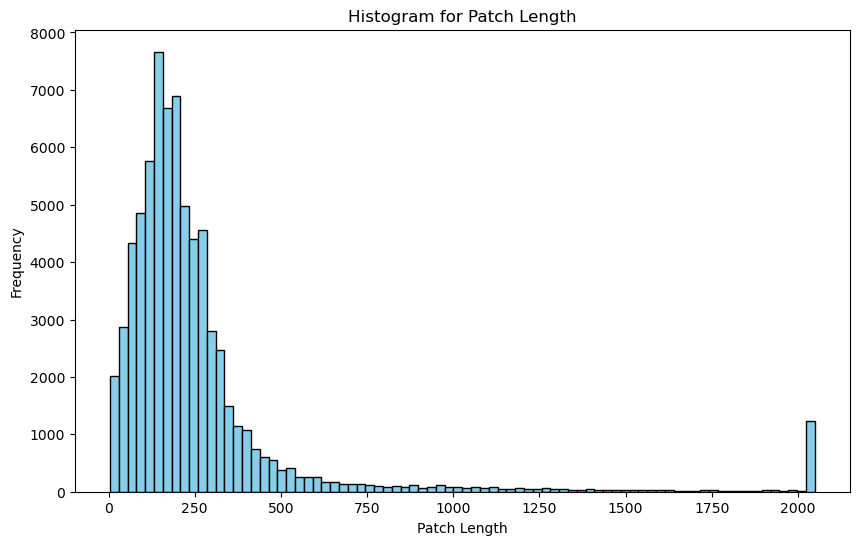

In [151]:
# histogram of patch lengths
plt.figure(figsize=(10, 6))
plt.hist(all_lens, bins=80, color='skyblue',edgecolor='black')
plt.xlabel('Patch Length')
plt.ylabel('Frequency')
plt.title('Histogram for Patch Length')
plt.show()

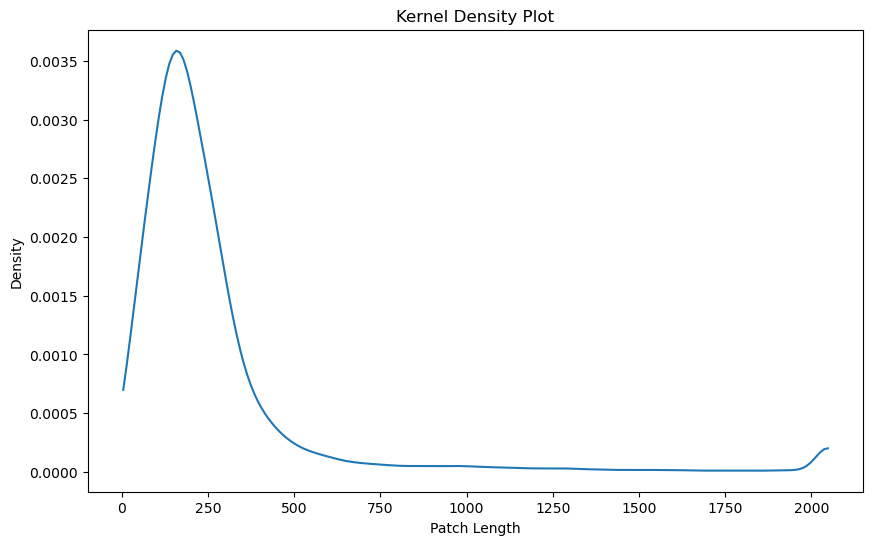

In [123]:
# density plot
density = gaussian_kde(all_lens)

# Create a range of x values for plotting
x = np.linspace(min(all_lens), max(all_lens), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Patch Length')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

In [257]:
# important statistics
print(np.median(all_lens))
print(np.percentile(all_lens, 25))
print(np.percentile(all_lens, 75))
print(stats.mode(all_lens))
min(all_lens)

188.0
124.0
276.0
ModeResult(mode=2048.0, count=1220)


4.0

## Looking at Outlying Cases in Detail

In [199]:
metrics_df[metrics_df['num_patches']<50]

,slice,num_patches,epithelium_coverage,case,Class
9,case_28_unmatched_1_h&e,26.0,97.851950,28,1
11,case_40_match_3_h&e,42.0,99.790971,40,4
16,case_63_match_2_h&e,49.0,96.607591,63,3
26,case_38_match14_sox10,17.0,99.914552,38,4
30,case_070_match_6_melan,37.0,99.632820,70,4
...,...,...,...,...,...
629,case_14_match_3_sox10,45.0,99.302244,14,4
630,case_42_match_2_h&e,28.0,93.258709,42,3
631,case_63_match_7_h&e,10.0,91.417216,63,3
633,case_88_unmatched2_h&e,19.0,94.213062,88,4


In [261]:
metrics_df['num_patches'].nsmallest(10)

70      1.0
128     1.0
617     4.0
374     5.0
508     5.0
527     5.0
204     9.0
268    10.0
376    10.0
460    10.0
Name: num_patches, dtype: float64

In [241]:
metrics_df[metrics_df['epithelium_coverage']<85]

,slice,num_patches,epithelium_coverage,case,Class
76,case_066_match_4_melan,150.0,84.589035,66,3
98,case_50_match_4_melan,40.0,79.066646,50,3
175,case_50_match_3_melan,334.0,82.624301,50,3
202,case_19_match_2_melan,152.0,72.037059,19,3
236,case_38_match_27_melan,27.0,73.091255,38,4
241,case_38_match13_h&e,31.0,67.737730,38,4
257,case_38_match_31_h&e,46.0,80.717639,38,4
267,case_50_match_3_sox10,237.0,81.711564,50,3
280,case_066_match_3_melan,94.0,80.597726,66,3
392,case_038_match_11_melan,54.0,80.702881,38,4


In [249]:
metrics_df['epithelium_coverage'].nsmallest(5)

241    67.737730
202    72.037059
236    73.091255
456    74.200038
622    76.936591
Name: epithelium_coverage, dtype: float64

In [255]:
metrics_df.iloc[456,:]

slice                  case_038_match_11_sox10
num_patches                               30.0
epithelium_coverage                  74.200038
case                                        38
Class                                        4
Name: 456, dtype: object

In [191]:
# num of patches with len < 10
count = 0
for val in all_lens:
    if val < 10:
        count += 1
count

395

## Aggregating into Case Level Data

In [135]:
# create case aggregated dataframe
agg_df = metrics_df.groupby('case').agg({
    'num_patches': 'sum',  # summing number of patches
    'epithelium_coverage': 'mean'  # average epithelium coverage across slices
}).reset_index()

# Merge on 'case' (inner join ensures only matching cases are kept)
agg_df = agg_df.merge(case_grade[['case', 'Class']], on='case', how='left')
agg_df.head()

,case,num_patches,epithelium_coverage,Class
0,1,452.0,93.897557,4
1,2,673.0,94.076937,1
2,3,862.0,96.870209,4
3,4,941.0,93.507114,1
4,5,508.0,97.414672,3


## Class-Based Distributions

In [137]:
# extract slice level segregation of high-grade versus benign
high_grade_slice = metrics_df[metrics_df['Class'].isin([3,4])].reset_index(drop=True)
benign_slice = metrics_df[metrics_df['Class'].isin([0,1])].reset_index(drop=True)
print("Total high-grade patches =", sum(high_grade_slice['num_patches']))
print("Total benign patches =", sum(benign_slice['num_patches']))

Total high-grade patches = 50338.0
Total benign patches = 22339.0


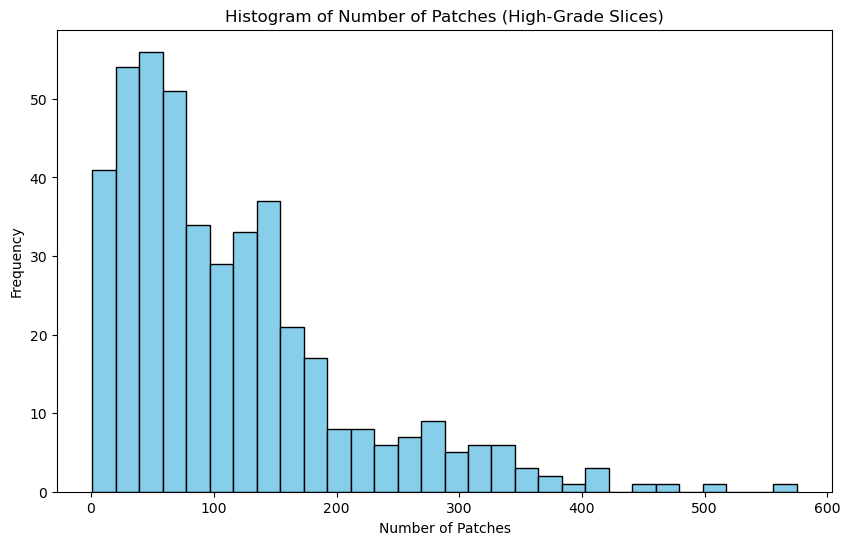

In [79]:
plt.figure(figsize=(10, 6))
plt.hist(high_grade_slice['num_patches'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Patches (High-Grade Slices)')
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.show()

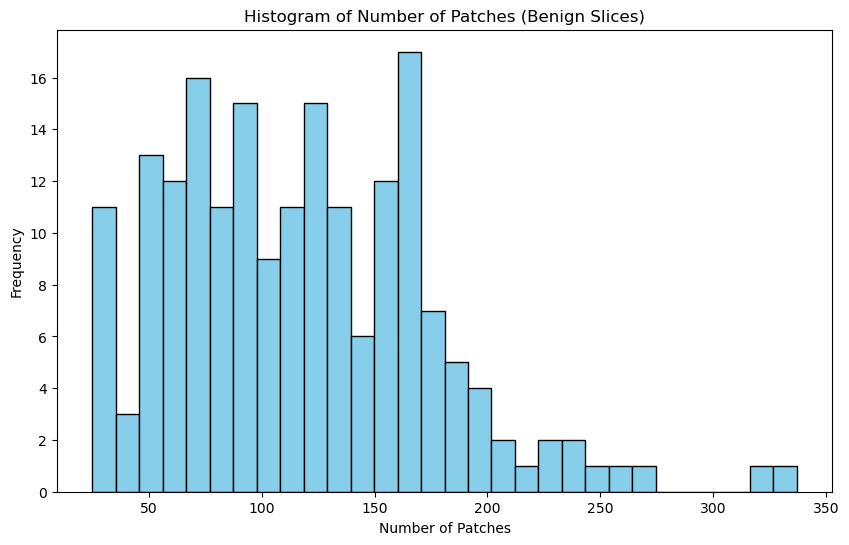

In [81]:
plt.figure(figsize=(10, 6))
plt.hist(benign_slice['num_patches'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Patches (Benign Slices)')
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.show()

### Takeaways and Questions

- Other than the outliers, patches seem to be well-formed and substantially cover the epithelium for the most part
- However, slices from cases such as 16, 63, 38, and 50 to name a few that commonly pop up in the list of outliers should be left out from our models for now, to prevent feeding in bad quality training data
- A lot of the issues still persist due to bad annotations
Should consider trade-off of spending another week fixing those patches (by re-annotating) versus completely moving focus to model-building. - Is the number of “bad” slices high enough to allocate more time toward patching? 



Question for Krish: What is Class = 0? Might be affecting our models since we assign anything not 1 as high grade in labels_map. Also affecting our patch analysis.

Answered: Case 65 marked as class 0 since it has not been classified yet. Ignore for now.